In [1]:
from __future__ import print_function
#%tensorflow_version 1.x

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

import math
import os
import errno
import shutil

In [2]:
PLOT_DIR = './out/plots'

In [3]:
def get_grid_dim(x):
    """
    Transforms x into product of two integers
    :param x: int
    :return: two ints
    """
    factors = prime_powers(x)
    if len(factors) % 2 == 0:
        i = int(len(factors) / 2)
        return factors[i], factors[i - 1]

    i = len(factors) // 2
    return factors[i], factors[i]


def prime_powers(n):
    """
    Compute the factors of a positive integer
    Algorithm from https://rosettacode.org/wiki/Factors_of_an_integer#Python
    :param n: int
    :return: set
    """
    factors = set()
    for x in range(1, int(math.sqrt(n)) + 1):
        if n % x == 0:
            factors.add(int(x))
            factors.add(int(n // x))
    return sorted(factors)


def empty_dir(path):
    """
    Delete all files and folders in a directory
    :param path: string, path to directory
    :return: nothing
    """
    for the_file in os.listdir(path):
        file_path = os.path.join(path, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print ('Warning: {}'.format(e))


def create_dir(path):
    """
    Creates a directory
    :param path: string
    :return: nothing
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise


def prepare_dir(path, empty=False):
    """
    Creates a directory if it soes not exist
    :param path: string, path to desired directory
    :param empty: boolean, delete all directory content if it exists
    :return: nothing
    """
    if not os.path.exists(path):
        create_dir(path)

    if empty:
        empty_dir(path)

In [4]:
def plot_conv_weights(weights, name, channels_all=True):
    """
    Plots convolutional filters
    :param weights: numpy array of rank 4
    :param name: string, name of convolutional layer
    :param channels_all: boolean, optional
    :return: nothing, plots are saved on the disk
    """
    # make path to output folder
    plot_dir = os.path.join(PLOT_DIR, 'conv_weights')
    plot_dir = os.path.join(plot_dir, name)

    # create directory if does not exist, otherwise empty it
    # utils.prepare_dir(plot_dir, empty=True)
    prepare_dir(plot_dir, empty=True)

    w_min = np.min(weights)
    w_max = np.max(weights)

    channels = [0]
    # make a list of channels if all are plotted
    if channels_all:
        channels = range(weights.shape[2])

    # get number of convolutional filters
    num_filters = weights.shape[3]

    # get number of grid rows and columns
    grid_r, grid_c = get_grid_dim(num_filters)

    # create figure and axes
    fig, axes = plt.subplots(min([grid_r, grid_c]),
                             max([grid_r, grid_c]))

    # iterate channels
    for channel in channels:
        # iterate filters inside every channel
        for l, ax in enumerate(axes.flat):
            # get a single filter
            img = weights[:, :, channel, l]
            # put it on the grid
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
            # remove any labels from the axes
            ax.set_xticks([])
            ax.set_yticks([])
        # save figure
        plt.savefig(os.path.join(plot_dir, '{}-{}.png'.format(name, channel)), bbox_inches='tight')


def plot_conv_output(conv_img, name):
    """
    Makes plots of results of performing convolution
    :param conv_img: numpy array of rank 4
    :param name: string, name of convolutional layer
    :return: nothing, plots are saved on the disk
    """
    # make path to output folder
    plot_dir = os.path.join(PLOT_DIR, 'conv_output')
    plot_dir = os.path.join(plot_dir, name)

    # create directory if does not exist, otherwise empty it
    prepare_dir(plot_dir, empty=True)

    w_min = np.min(conv_img)
    w_max = np.max(conv_img)

    # get number of convolutional filters
    num_filters = conv_img.shape[3]

    # get number of grid rows and columns
    grid_r, grid_c = get_grid_dim(num_filters)

    # create figure and axes
    fig, axes = plt.subplots(min([grid_r, grid_c]),
                             max([grid_r, grid_c]))

    # iterate filters
    for l, ax in enumerate(axes.flat):
        # get a single image
        img = conv_img[0, :, :,  l]
        # put it on the grid
        ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='bicubic', cmap='Greys')
        # remove any labels from the axes
        ax.set_xticks([])
        ax.set_yticks([])
    # save figure
    plt.savefig(os.path.join(plot_dir, '{}.png'.format(name)), bbox_inches='tight')

In [5]:
mnist = input_data.read_data_sets("./data/", one_hot=True)

# Parameters
learning_rate = 0.001
training_iters = 10000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)
dropout = 0.75  # Dropout, probability to keep units

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)  # dropout (keep probability)


def conv2d(x_, filter_size, filter_num, stride=1):
    """
    Wrapper of a convolutional layer
    :param x_: tensor, input to convolutional layer
    :param filter_size: int, size of a convolutional kernel
    :param filter_num: int, number of convolutional kernels
    :param stride: int, optional, stride
    :return: tensor
    """
    # get number of channels in input
    channels = x_.get_shape()[3].value

    # create weights tensor
    weights = tf.Variable(tf.random_normal([filter_size, filter_size, channels, filter_num]))

    # add weights tensor to collection
    tf.add_to_collection('conv_weights', weights)

    # create bias tensor
    bias = tf.Variable(tf.random_normal([filter_num]))

    # apply weights and biases
    preactivations = tf.nn.conv2d(x_, weights, strides=[1, stride, stride, 1], padding='SAME')
    preactivations = tf.nn.bias_add(preactivations, bias)

    # apply activation function, this is layer output
    activations = tf.nn.relu(preactivations)

    # add output to collection
    tf.add_to_collection('conv_output', activations)

    return activations


def fc(x_, nodes, keep_prob_=1, act=tf.nn.relu):
    """
    Wrapper for fully-connected layer
    :param x_: tensor, input to fully-connected alyer
    :param nodes: int, number of nodes in layer
    :param keep_prob_: float, optional, keep probability for dropout operation
    :param act: tf.nn method, optional, activation function
    :return: tensor
    """
    shape = x_.get_shape()

    # if rank of input tensor is greater than 2
    # we need to reshape it
    if shape.ndims > 2:
        n = 1
        for s in shape[1:]:
            n *= s.value
        x_ = tf.reshape(x_, tf.stack([-1, n]))
        x_.set_shape([None, n])

    # get number of column in input tensor
    n = x_.get_shape()[1].value

    # create weights
    weights = tf.Variable(tf.random_normal([n, nodes]))

    # create biases
    bias = tf.Variable(tf.random_normal([nodes]))

    # apply weights and bias
    preactivate = tf.add(tf.matmul(x_, weights), bias)
    out = preactivate

    # apply activation function if not None
    if act is not None:
        out = act(preactivate)

    # apply dropout
    out = tf.nn.dropout(out, keep_prob_)

    return out


def maxpool(x_, size, stride):
    """
    Wrapper for max-pooling layer
    :param x_: tensor, input to max-pooling layer
    :param size: int
    :param stride: int
    :return: tensor
    """
    return tf.nn.max_pool(x_,
                          ksize=[1, size, size, 1],
                          strides=[1, stride, stride, 1],
                          padding='SAME')

# Reshape inputs
x_reshaped = tf.reshape(x, shape=[-1, 28, 28, 1])

# First convolutional layer
predictions = conv2d(x_reshaped, filter_size=5, filter_num=32)

# First max-pooling layer
predictions = maxpool(predictions, 2, 2)

# Second convolutional layer
predictions = conv2d(predictions, filter_size=5, filter_num=64)

# Second max-pooling layer
predictions = maxpool(predictions, 2, 2)

# First fully-connected layer
predictions = fc(predictions, 1024, keep_prob)

# Output layer, no activation function
# This layer returns logits
predictions = fc(predictions, n_classes, keep_prob, act=None)

# Define loss operation
#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(predictions, y))
val = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y, logits = predictions) 
cost = tf.reduce_mean(val)


# Define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Define accuracy operation
correct_predictions = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [6]:
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                   keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                          y: batch_y,
                                                          keep_prob: 1.})
            print("\rIter " + str(step*batch_size) + ", Minibatch Loss= " +
              "{:.6f}".format(loss) + ", Training Accuracy= " +
              "{:.5f}".format(acc), end='')
        step += 1
    print("\rOptimization Finished!")
    # Calculate accuracy for 256 mnist test images
    print("Testing Accuracy:",
    sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
                                y: mnist.test.labels[:256],
                                keep_prob: 1.}))
    # no need for feed dictionary here
    conv_weights = sess.run([tf.get_collection('conv_weights')])
    conv_out = sess.run([tf.get_collection('conv_output')], feed_dict={x: mnist.test.images[:1]})
    print("conv_weights & conv_out done!")    

Optimization Finished!oss= 2200.709473, Training Accuracy= 0.820312
Testing Accuracy: 0.796875
conv_weights & conv_out done!


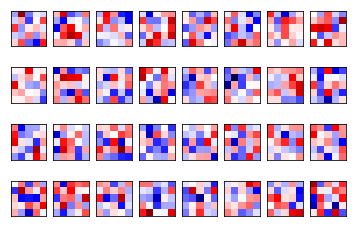

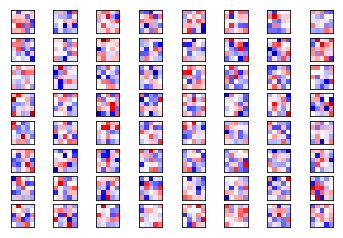

In [7]:
  # get weights of all convolutional layers
  # no need for feed dictionary here 
  for i, c in enumerate(conv_weights[0]):
        plot_conv_weights(c, 'conv{}'.format(i))

In [8]:
 # get output of all convolutional layers
 # here we need to provide an input imag   
   for i, c in enumerate(conv_out[0]): 
        plot_conv_output(c, 'conv{}'.format(i))
#        

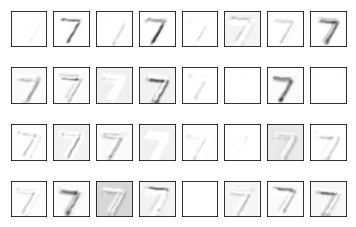

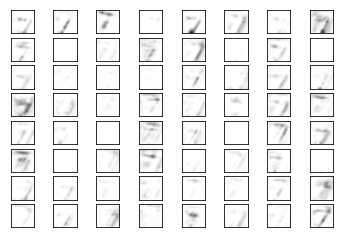

In [9]:
#

In [13]:
!ls -lR

.:
total 8
drwxr-x--- 2 dsxuser dsxuser 4096 May 27 07:18 data
drwxr-x--- 3 dsxuser dsxuser 4096 May 27 07:22 out

./data:
total 11336
-rw-r----- 1 dsxuser dsxuser 1648877 May 27 07:18 t10k-images-idx3-ubyte.gz
-rw-r----- 1 dsxuser dsxuser    4542 May 27 07:18 t10k-labels-idx1-ubyte.gz
-rw-r----- 1 dsxuser dsxuser 9912422 May 27 07:18 train-images-idx3-ubyte.gz
-rw-r----- 1 dsxuser dsxuser   28881 May 27 07:18 train-labels-idx1-ubyte.gz

./out:
total 4
drwxr-x--- 4 dsxuser dsxuser 4096 May 27 07:27 plots

./out/plots:
total 8
drwxr-x--- 4 dsxuser dsxuser 4096 May 27 07:27 conv_output
drwxr-x--- 4 dsxuser dsxuser 4096 May 27 07:22 conv_weights

./out/plots/conv_output:
total 8
drwxr-x--- 2 dsxuser dsxuser 4096 May 27 07:40 conv0
drwxr-x--- 2 dsxuser dsxuser 4096 May 27 07:40 conv1

./out/plots/conv_output/conv0:
total 24
-rw-r----- 1 dsxuser dsxuser 21519 May 27 07:40 conv0.png

./out/plots/conv_output/conv1:
total 28
-rw-r----- 1 dsxuser dsxuser 27303 May 27 07:40 conv1.png

./out/plot

In [14]:
print(conv_weights[0])

[array([[[[-6.13871455e-01,  3.45127463e-01, -4.85216141e-01,
          -2.46876433e-01,  4.13669236e-02, -1.56512424e-01,
           1.25988531e+00, -2.17700396e-02,  1.36365052e-02,
          -1.96721315e+00,  1.96153730e-01,  2.01394534e+00,
          -3.76525491e-01, -1.06653154e+00,  4.01817799e-01,
          -5.06186724e-01,  7.62073398e-01,  1.09953009e-01,
           2.43531868e-01, -6.31347656e-01, -1.08707912e-01,
           1.39358950e+00,  1.09938252e+00,  9.25026596e-01,
          -3.63032743e-02,  6.70154631e-01,  6.18752718e-01,
           8.43371391e-01, -1.84362665e-01, -1.89105570e-01,
          -7.11738169e-01,  2.52985358e+00]],

        [[ 2.73174119e+00,  1.94035673e+00,  1.49463928e+00,
          -1.86606848e+00, -9.97276425e-01,  9.21345592e-01,
          -4.04840171e-01, -6.13288820e-01,  4.90777530e-02,
           6.43604755e-01, -3.59415650e-01,  1.03487492e+00,
           8.94470751e-01,  4.54964489e-01,  2.17371807e-01,
          -1.36694169e+00, -1.5902814

In [15]:
print(conv_out[0])

[array([[[[-0.        , -0.        , -0.        , ...,  0.6314195 ,
           0.28227648,  0.48884043],
         [-0.        , -0.        , -0.        , ...,  0.6314195 ,
           0.28227648,  0.48884043],
         [-0.        , -0.        , -0.        , ...,  0.6314195 ,
           0.28227648,  0.48884043],
         ...,
         [-0.        , -0.        , -0.        , ...,  0.6314195 ,
           0.28227648,  0.48884043],
         [-0.        , -0.        , -0.        , ...,  0.6314195 ,
           0.28227648,  0.48884043],
         [-0.        , -0.        , -0.        , ...,  0.6314195 ,
           0.28227648,  0.48884043]],

        [[-0.        , -0.        , -0.        , ...,  0.6314195 ,
           0.28227648,  0.48884043],
         [-0.        , -0.        , -0.        , ...,  0.6314195 ,
           0.28227648,  0.48884043],
         [-0.        , -0.        , -0.        , ...,  0.6314195 ,
           0.28227648,  0.48884043],
         ...,
         [-0.        , -0.       